In [1]:
import pandas as pd
import numpy as np

In [37]:
import re

In [5]:
from sklearn.decomposition import PCA

In [101]:
from sklearn.manifold import TSNE, MDS

In [84]:
import matplotlib.pyplot as plt

In [11]:
countries_data = pd.read_csv("../Data/Processed/worried_data_processed.csv", index_col= "Country Name")

In [35]:
worried_desc_path = "../Data/Processed/worried_desc.txt"
with open(worried_desc_path, "r") as f:
    worried_desc = f.read().split('\n')

In [67]:
series_desc = {}
for line in worried_desc:
    code, val = (re.search(r'\| (.*) \| (.*) \|', line)).groups()
    series_desc[code] = val

In [15]:
X = countries_data.values

# Principal Component Analysis (PCA)

In [19]:
pca = PCA(n_components = 132)
X_PCA = pca.fit_transform(X)
expl_var = np.cumsum(pca.explained_variance_ratio_)
expl_var_thresh = [0.75, 0.9, 0.95, 0.99]
# no of principal components explaining subsequent values in expl_var_tresh
pca_comp_no = []
for thresh in expl_var_thresh:
    dim_no = np.argmax(expl_var > thresh) + 1
    pca_comp_no.append(dim_no)
    print("Number of principal components which explain", thresh * 100, "% of variance:", dim_no)

Number of principal components which explain 75.0 % of variance: 1
Number of principal components which explain 90.0 % of variance: 3
Number of principal components which explain 95.0 % of variance: 7
Number of principal components which explain 99.0 % of variance: 22


### Observations on the PCA’s Explained Variance
The columns of the design matrix are correlated because of the specificity of the data. There are three main survey topics involved: concerns about day-to-day expenses, educational expenses, and money for old age. The rest of the series are stratifications of the data that may initially seem redundant, but they can provide important information about smaller effects that differentiate countries. This is reflected in the bulk of the explained variance being concentrated in the first principal component. The first two principal components together account for 88% of the variance, followed by a long tail of principal components, each explaining only a small fraction of the variance.

## PCA Loadings

In [82]:
# The variables which contribute the most to the first principal component
# loading : variable description
indices =np.flip(np.argsort(np.abs(pca.components_[0,:])))
loop_cnt = 50
for i in indices:
    print(pca.components_[0,:][i], ":", series_desc[countries_data.columns[i]])
    loop_cnt -= 1
    if loop_cnt == 0:
        break

0.1307274597908873 : Worried about not being able to pay for medical costs in case of a serious illness or accident: very worried, older (% age 25+)
0.12891089074891332 : Worried about not being able to pay for medical costs in case of a serious illness or accident: very worried, in labor force (% age 15+)
0.12652898484904287 : Worried about not being able to pay school fees or fees for education: very worried, income, poorest 40% (% ages 15+)
0.12635193053850904 : Worried about not being able to pay for medical costs in case of a serious illness or accident: very worried, income, richest 60% (% ages 15+)
0.12622327989167023 : Worried about not being able to pay for medical costs in case of a serious illness or accident: very worried, male (% age 15+)
0.12605743198638145 : Worried about not being able to pay for medical costs in case of a serious illness or accident: very worried (% age 15+)
0.12591957771301518 : Worried about not being able to pay for medical costs in case of a seriou

### Observations on PCA Loadings
The loadings of the first principal component are roughly the same. No single variable stands out, but all variables move together according to their sign. This reflects the structure of the dataset, which stratifies the answers to three main questions. Because the percentages of each group—"very worried," "somewhat worried," and "not worried at all"—sum to 100, “very worried” moves in the opposite direction from “not worried at all.”

## PCA Visualisations

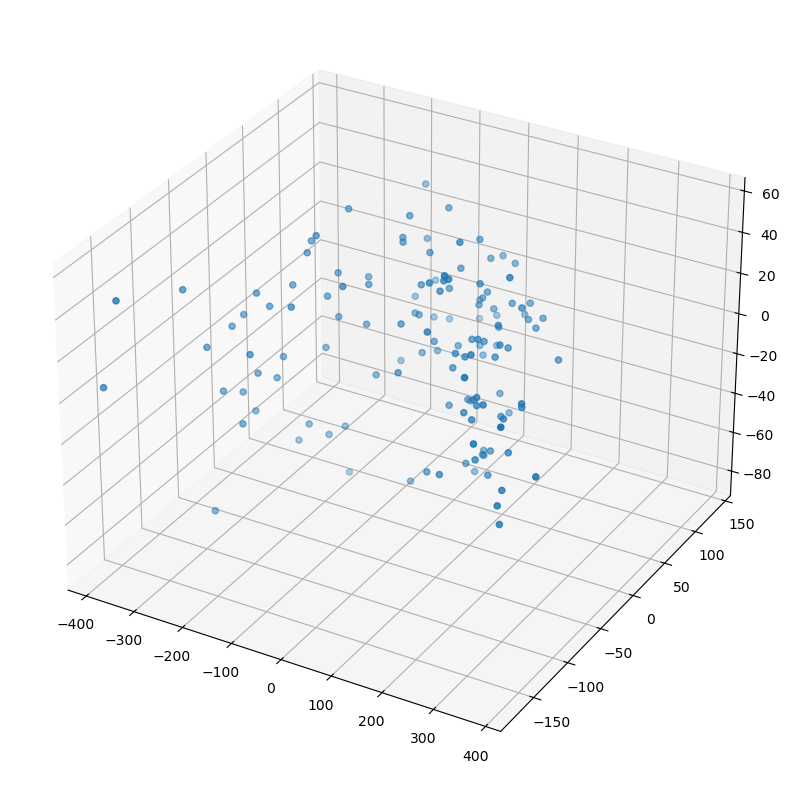

<Figure size 640x480 with 0 Axes>

In [97]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
ax.scatter3D(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2])
plt.show()
plt.savefig("../Results/PCA3D.png")

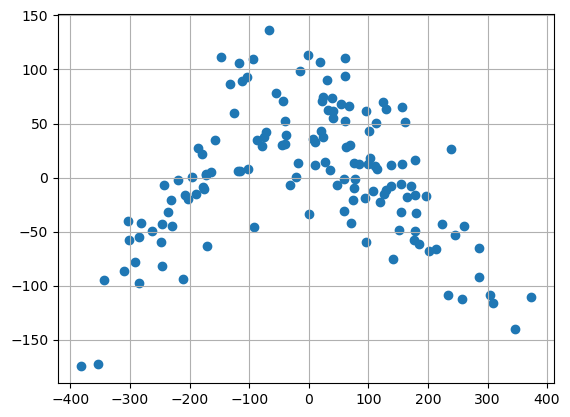

In [99]:
plt.scatter(X_PCA[:,0], X_PCA[:,1])
plt.grid(True)
plt.show
plt.savefig("../Results/PCA2D.png")

### Implications for the Choice of Clustering Algorithms
Despite 2D and 3D visualizations not revealing any obvious clusters, I still plan to try K-means, even though the structure doesn’t suggest spherical clusters based on the visual inspection. In 3D space, the data appears as a cloud with varying densities—hence my motivation to try K-means. Meanwhile, the 2D projection looks like a crescent-shaped cloud, which is why I also want to use DBSCAN to see if it identifies boundaries along the crescent. Additionally, I intend to explore MDS and t-SNE visualizations to gain further insight into the data’s structure.

# MDS

In [108]:
mds = MDS(n_components = 3)
X_MDS = mds.fit_transform(X)

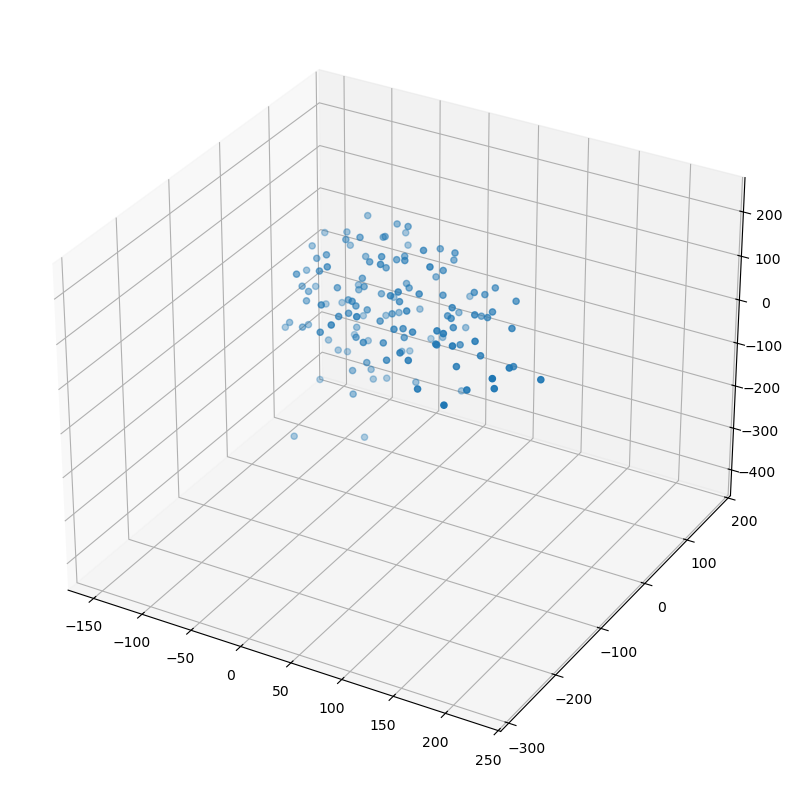

<Figure size 640x480 with 0 Axes>

In [114]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
ax.scatter3D(X_MDS[:,0], X_MDS[:,1], X_MDS[:,2])
plt.show()
plt.savefig("../Results/MDS3D.png")

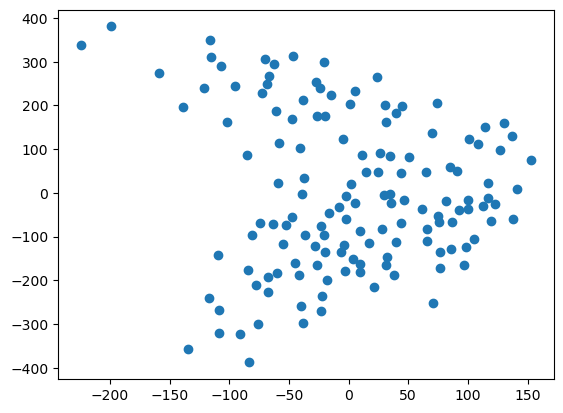

<Figure size 640x480 with 0 Axes>

In [107]:
plt.scatter(X_MDS[:,0], X_MDS[:,1])
plt.show()
plt.savefig("../Results/MDS.png")

### Observations on MDS visualisations.
In the 3D plot, the points appear roughly equidistant. The 2D plot does not reveal any additional structural information beyond what was observed earlier.

# t-SNE

## Choosing Perplexity

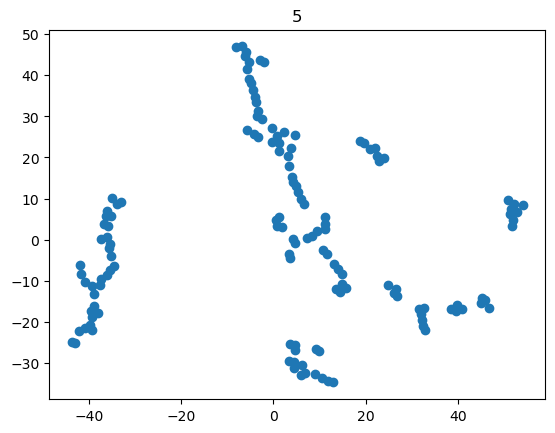

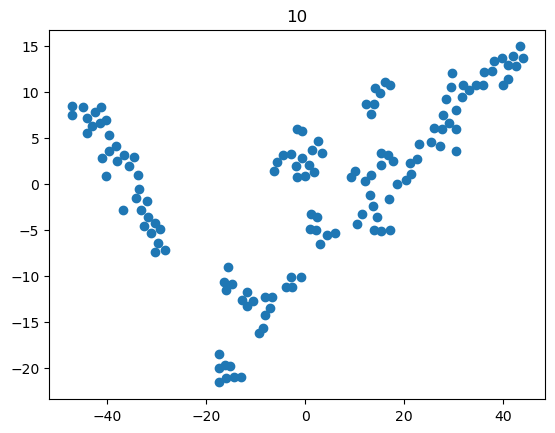

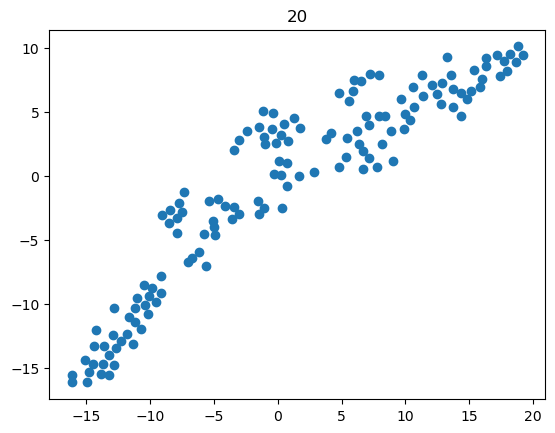

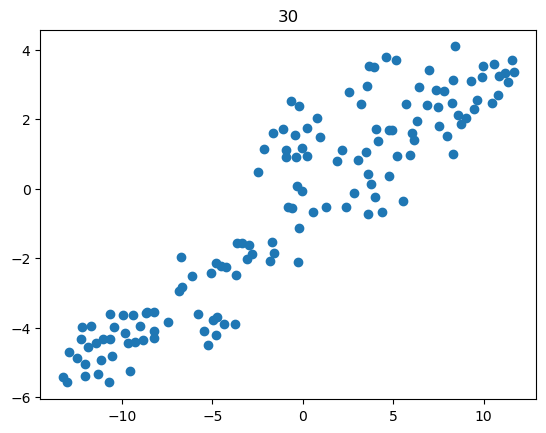

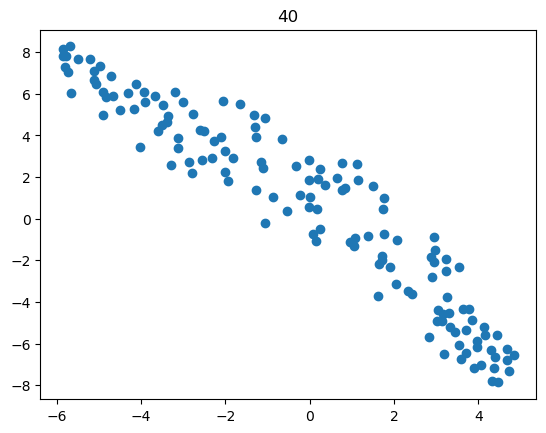

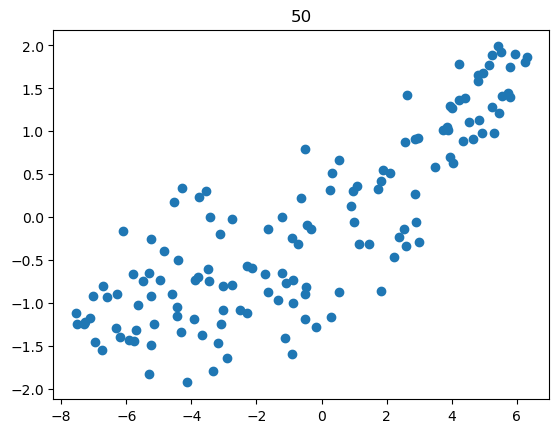

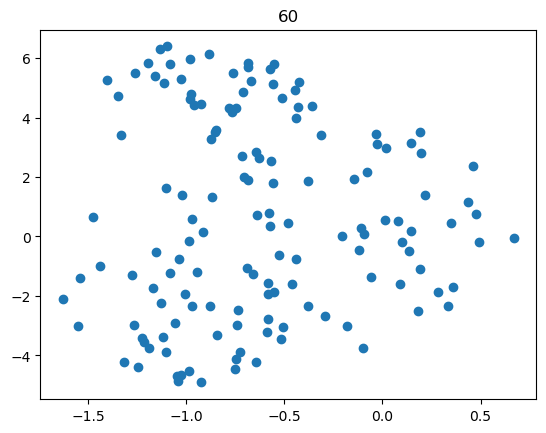

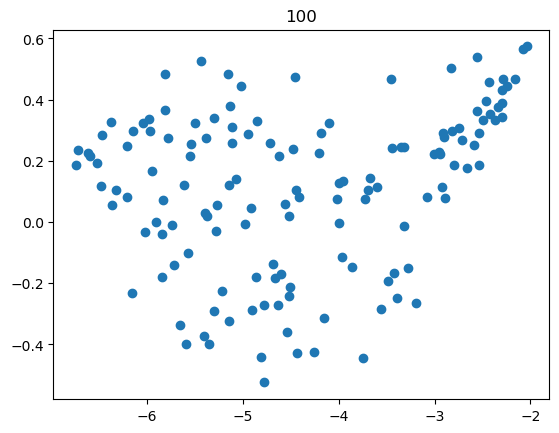

In [139]:
perpl = [5, 10, 20, 30, 40, 50, 60, 100]

for p in perpl:
    tsne = TSNE(n_components = 2, perplexity = p)
    # using 88% of the explained variance
    tsne_data = tsne.fit_transform(X_PCA[:, 0:2])
    plt.scatter(tsne_data[:,0], tsne_data[:,1])
    plt.title(p)
    plt.show()

### Observations on the Perplexity Choice
It appears that a perplexity value of 10 provides a visualization that highlights potential structures of interest, which higher perplexity values tend to mask. Choosing a low perplexity preserves local neighborhoods and exaggerates distances between them, which may result in overfitting and the discovery of spurious structures. Conversely, a high perplexity reveals the global structure at the expense of masking some meaningful locally observed patterns. Further analysis is required to evaluate whether the clusters are artifacts of the chosen parameters or genuinely reflect meaningful structures.

## The impact of the Number of the Principal Components

In [144]:
# Since the number of principal components required for visualisation is 2, the lowest values of PCs is 2
pca_comp_no[0] += 1

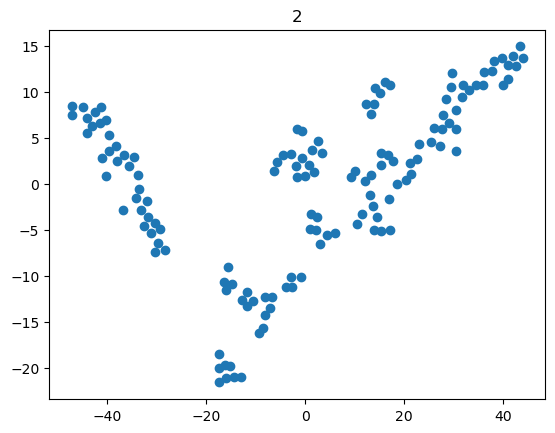

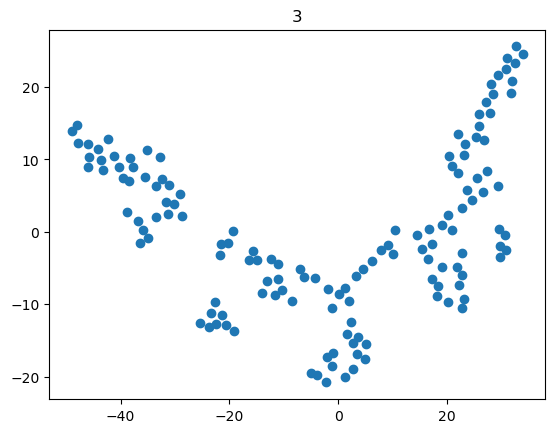

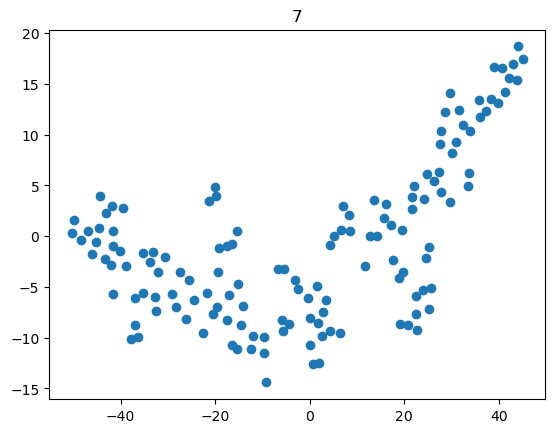

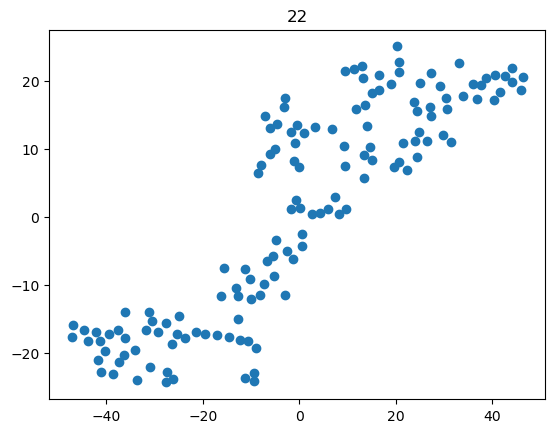

In [143]:
for pcs in pca_comp_no:
    tsne = TSNE(n_components = 2, perplexity = 10)
    tsne_data = tsne.fit_transform(X_PCA[:, 0:pcs])
    plt.scatter(tsne_data[:,0], tsne_data[:,1])
    plt.title(pcs)
    plt.show()

### Observations on the Number of Principal Components Provided to t-SNE
It appears that providing fewer principal components (PCs) results in t-SNE embeddings that reveal more distinct cluster structures. t-SNE is known to perform better when not overwhelmed by excessive variance. In this case, 2 PCs explain 88% of the variance, and 3 PCs explain over 90% of the variance. Including more PCs introduces the tail of components, each explaining only a small fraction of the variance, which does not contribute to uncovering meaningful patterns within the data.